### Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import time

### Data Preprocessing

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("feyzazkefe/trashnet")

# print("Path to dataset files:", path)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
data_dir = r'C:\Users\baoba\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1\dataset-resized'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_dir, transform=transformations)

In [6]:
import matplotlib.pyplot as plt
def show_image(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: glass (Class No: 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4482791].


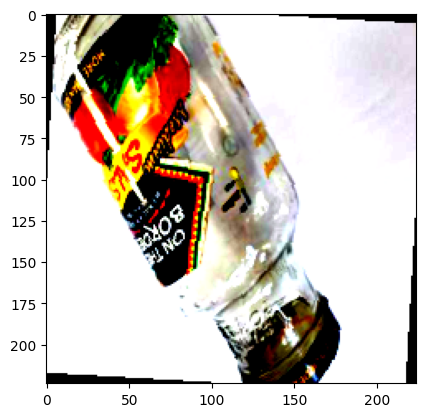

In [7]:
img, label = dataset[536]
show_image(img, label)

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(2021, 252, 254)

In [10]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_dataset, BATCH_SIZE*2, num_workers = 4, pin_memory = True)

### Resnet

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x) 
        out = F.relu(out)
        return out

In [12]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        # 1x1 conv: Giảm số channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 conv: Xử lý không gian
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 conv: Tăng số channels lên gấp 4 lần (expansion)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU()
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6, use_dropout=False):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.use_dropout = use_dropout

        # Lớp đầu vào (Initial Conv)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Các lớp Residual (4 layers)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [14]:
def inject_imagenet_weights(custom_model, version):
    if version == 18:
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif version == 34:
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    elif version == 50:
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif version == 101:
        model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
    elif version == 152:
        model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
    pretrained_dict = model.state_dict()
    model_dict = custom_model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                       if k in model_dict and v.shape == model_dict[k].shape}
    custom_model.load_state_dict(pretrained_dict, strict=False)
    return custom_model

def ResNet18(num_classes):
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    model = inject_imagenet_weights(model, 18)
    return model

def ResNet34(num_classes):
    model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)
    model = inject_imagenet_weights(model, 34)
    return model

def ResNet50(num_classes):
    model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
    model = inject_imagenet_weights(model, 50)
    return model

def ResNet101(num_classes):
    model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)
    model = inject_imagenet_weights(model, 101)
    return model

def ResNet152(num_classes):
    model = ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)
    model = inject_imagenet_weights(model, 152)
    return model

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)         
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
class GarbageClassifier(ImageClassificationBase):
    def __init__(self, num_classes, version):
        super().__init__()
        if version==18:
            network = ResNet18(num_classes)
        elif version==34:
            network = ResNet34(num_classes)
        elif version==50:
            network = ResNet50(num_classes)
        elif version==101:
            network = ResNet101(num_classes)
        elif version==152:
            network = ResNet152(num_classes)
        self.network = network
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return self.network(xb)
num_classes = len(classes)
model_18 = GarbageClassifier(num_classes, 18)
model_34 = GarbageClassifier(num_classes, 34)
model_50 = GarbageClassifier(num_classes, 50)
model_101 = GarbageClassifier(num_classes, 101)
model_152 = GarbageClassifier(num_classes, 152)
model_18.to(device)
model_34.to(device)
model_50.to(device)
model_101.to(device)
model_152.to(device)

Using cuda


GarbageClassifier(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (downsample): Sequential(
          (0): Conv2d(64

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs.append(model.validation_step((images, labels)))
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    total_train_start = time.time()    

    for epoch in range(epochs):
        epoch_start = time.time() 

        # ===== Training Phase =====
        model.train()
        train_losses = []
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            loss = model.training_step((images, labels))
            train_losses.append(loss)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # ===== Validation Phase =====
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        model.epoch_end(epoch, result)
        
        # Thời gian epoch
        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{epochs}] finished in {epoch_time:.2f} sec")

        # Lưu vào lịch sử
        result['epoch_time'] = epoch_time
        history.append(result)

    total_time = time.time() - total_train_start
    print(f"\nTotal training time: {total_time:.2f} sec ({total_time/60:.2f} min)")

    return history


In [18]:
models = {
    18: model_18,
    34: model_34,
    50: model_50,
    101: model_101,
    152: model_152
}

histories = {}

num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

for version, model in models.items():
    print(f"\nTraining for ResNet{version}...")
    history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
    histories[version] = history


Training for ResNet18...
Epoch 1: train_loss: 0.9752, val_loss: 0.5634, val_acc: 0.7979
Epoch [1/20] finished in 34.23 sec
Epoch 2: train_loss: 0.4379, val_loss: 0.3782, val_acc: 0.8810
Epoch [2/20] finished in 63.93 sec
Epoch 3: train_loss: 0.2692, val_loss: 0.2950, val_acc: 0.8935
Epoch [3/20] finished in 49.62 sec
Epoch 4: train_loss: 0.2115, val_loss: 0.2725, val_acc: 0.8891
Epoch [4/20] finished in 48.13 sec
Epoch 5: train_loss: 0.1726, val_loss: 0.2551, val_acc: 0.8977
Epoch [5/20] finished in 44.97 sec
Epoch 6: train_loss: 0.1183, val_loss: 0.2882, val_acc: 0.8977
Epoch [6/20] finished in 41.47 sec
Epoch 7: train_loss: 0.0868, val_loss: 0.2235, val_acc: 0.9214
Epoch [7/20] finished in 44.81 sec
Epoch 8: train_loss: 0.0702, val_loss: 0.2637, val_acc: 0.9172
Epoch [8/20] finished in 44.26 sec
Epoch 9: train_loss: 0.0565, val_loss: 0.2623, val_acc: 0.9130
Epoch [9/20] finished in 47.05 sec
Epoch 10: train_loss: 0.0426, val_loss: 0.2428, val_acc: 0.9214
Epoch [10/20] finished in 38

Thời gian: ResNet18, ResNet34 và ResNet50 chạy nhanh nhất

In [19]:
def predict_image(img, model):
    model.eval()
    xb = img.unsqueeze(0).to(device)
    with torch.no_grad():
        yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [33]:
# 1. Tạo DataLoader cho tập Test (nếu chưa tạo)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, num_workers=4, pin_memory=True)

# 2. Hàm đánh giá độ chính xác
def evaluate_model_on_test(model, data_loader, device, model_name="Model"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Độ chính xác của {model_name} trên tập test ({total} ảnh): {accuracy:.2f}%')
    return accuracy
print("--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---")

# Đánh giá ResNet18
acc_18 = evaluate_model_on_test(model_18, test_loader, device, "ResNet18")

# Đánh giá ResNet50
acc_34 = evaluate_model_on_test(model_34, test_loader, device, "ResNet34")

# Đánh giá ResNet50
acc_50 = evaluate_model_on_test(model_50, test_loader, device, "ResNet50")

# Đánh giá ResNet101
acc_101 = evaluate_model_on_test(model_101, test_loader, device, "ResNet101")

# Đánh giá ResNet152
acc_152 = evaluate_model_on_test(model_152, test_loader, device, "ResNet152")

--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---
Độ chính xác của ResNet18 trên tập test (254 ảnh): 90.16%
Độ chính xác của ResNet34 trên tập test (254 ảnh): 93.31%
Độ chính xác của ResNet50 trên tập test (254 ảnh): 93.70%
Độ chính xác của ResNet101 trên tập test (254 ảnh): 92.91%
Độ chính xác của ResNet152 trên tập test (254 ảnh): 92.52%


Độ chính xác của ResNet18 cao hơn --> Chọn ResNet18

In [21]:
def predict_image(img, model):
    model.eval()
    xb = img.unsqueeze(0).to(device)
    with torch.no_grad():
        yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3760502].


Label: metal (Class No: 2)
Label: metal , Predicted: metal


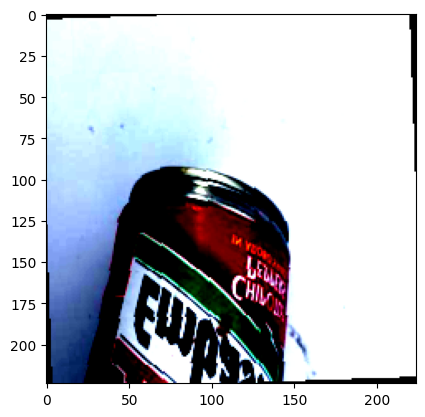

In [22]:
img, label = test_dataset[36]
show_image(img, label)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_18))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0125492].


Label: paper (Class No: 3)
Label: paper , Predicted: paper


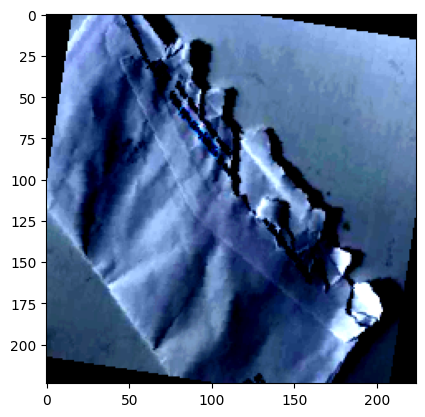

In [23]:
img, label = test_dataset[24]
show_image(img, label)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_18))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label: plastic (Class No: 4)
Label: plastic , Predicted: plastic


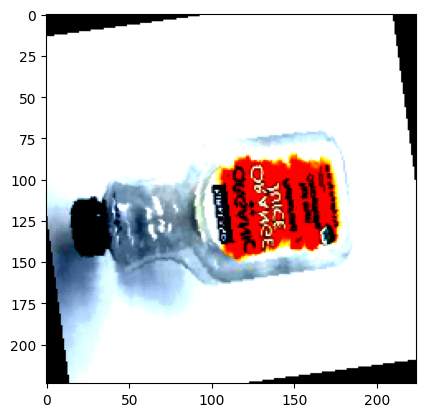

In [24]:
img, label = test_dataset[123]
show_image(img, label)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_18))

In [25]:
from PIL import Image
def predict_external_image(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transformations(img)
    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, dim=1)
    
    predicted_class = classes[preds[0].item()]
    
    # Hiển thị ảnh và kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Dự đoán: {predicted_class}")
    plt.show()
    
    return predicted_class

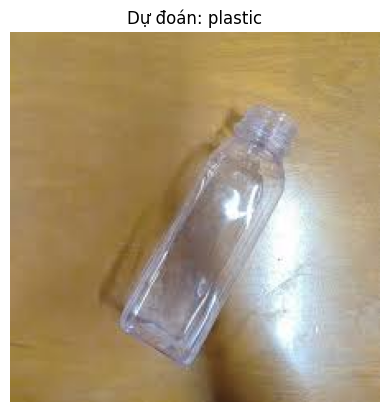

'plastic'

In [26]:
predict_external_image('image1.jpg', model_18)

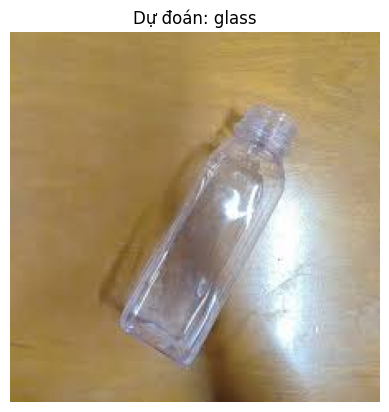

'glass'

In [27]:
predict_external_image('image1.jpg', model_50)

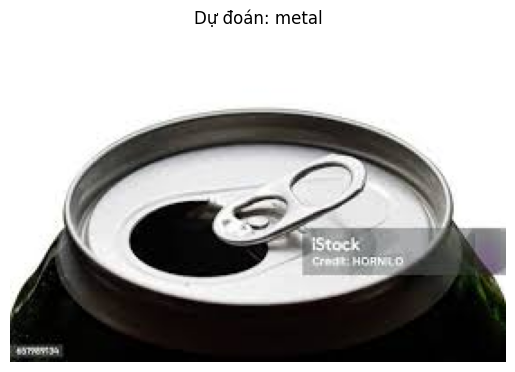

'metal'

In [28]:
predict_external_image('image2.jpg', model_18)

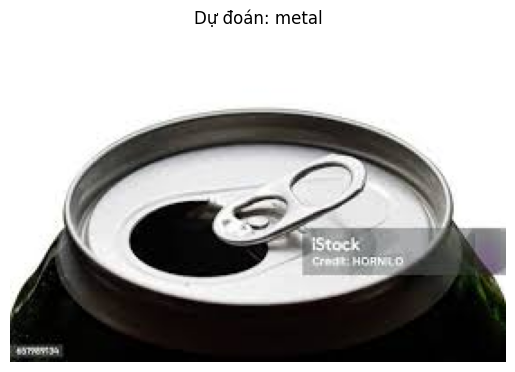

'metal'

In [29]:
predict_external_image('image2.jpg', model_50)

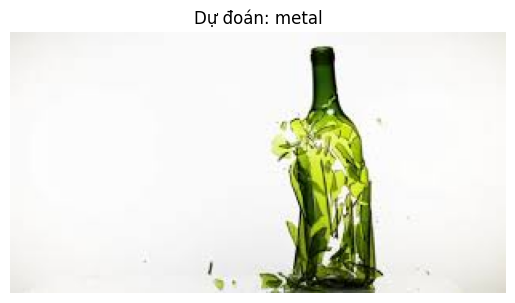

'metal'

In [30]:
predict_external_image('image3.jpg', model_18)

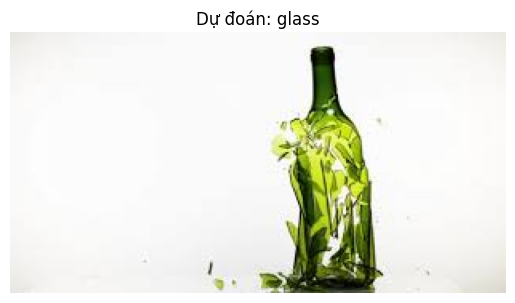

'glass'

In [31]:
predict_external_image('image3.jpg', model_50)